### Load the data

In [72]:
import torch
from transformer_lens import HookedTransformer, HookedTransformerConfig
from neel_plotly.plot import line
from helpers import loss_fn
from devinterp.slt.sampler import estimate_learning_coeff_with_summary, estimate_learning_coeff, SGLD
from devinterp.utils import plot_trace
import tqdm.auto as tqdm
import os
from pathlib import Path
from helpers import rolling_average

CREATE_ESTIMATES = True
TUNE_HYPERPARAMS = True

device = "cuda" if torch.cuda.is_available() else "cpu"
RAND_SEED = 42

if CREATE_ESTIMATES:
    LOAD_LOCATION = "../saves/check_point_50/grokking_addition.pth"

    cached_data = torch.load(LOAD_LOCATION, weights_only=False)

    state_dict = cached_data['model']
    model_checkpoints = cached_data["checkpoints"]
    checkpoint_epochs = cached_data["checkpoint_epochs"]
    test_losses = cached_data['test_losses']
    train_losses = cached_data['train_losses']
    #add_test_losses = cached_data['add_test_losses']
    #multi_test_losses = cached_data['multi_test_losses']
    max_nums = cached_data['max_nums']
    mod_value = cached_data['mod_value']
    train_frac = cached_data['train_frac']
    #addition_frac = cached_data['addition_frac']
    train_data = cached_data['train_data']
    train_labels = cached_data['train_labels']

    # print(f"train_frac = {train_frac} addition_frac = {addition_frac}")
    print(f"len(train_losses) = {len(train_losses)} len(test_losses) = {len(test_losses)} len(model_checkpoints) = {len(model_checkpoints)}")

len(train_losses) = 6000 len(test_losses) = 6000 len(model_checkpoints) = 120


In [73]:
from torch.utils.data import TensorDataset, DataLoader
if CREATE_ESTIMATES:
    train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)

### Setup the Model

In [74]:
if CREATE_ESTIMATES:
    cfg = HookedTransformerConfig(
        n_layers = 1,
        n_heads = 4,
        d_model = 128,
        d_head = 32,
        d_mlp = 512,
        act_fn = "relu",
        normalization_type=None, # "LN",
        d_vocab=max_nums+1,
        d_vocab_out=mod_value,
        n_ctx= 3,
        init_weights=True,
        device=device,
        seed = RAND_SEED,
    )

    model = HookedTransformer(cfg)

### Local Learning Coefficient (RLCT) Estimation

#### Config

In [75]:
lr = 3e-2
num_chains = 3
num_draws = 150
num_burnin_steps = 50
num_steps_bw_draws = 1
gamma = 5
nbeta = 1.6
sampling_method = "sgld"

def evaluate(model, data):
    inputs, outputs = data

    return loss_fn(model(inputs), outputs), {
        "logits": model(inputs)
    }

#### Find the right hyperparameters

In [77]:
import typing
from typing import Type

import numpy as np


def estimate_llc_given_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    evaluate: typing.Callable,
    epsilon: float,
    beta: float,
    sampling_method: Type[torch.optim.Optimizer] = SGLD,
    localization: float = 5.0,
    num_chains: int = 3,
    num_draws: int = 500,
    num_burnin_steps: int = 0,
    num_steps_bw_draws: int = 1,
    device: torch.device = torch.device("cpu"),
    online: bool = True,
    verbose: bool = False,
):

    sweep_stats = estimate_learning_coeff_with_summary(
        model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=sampling_method,
        optimizer_kwargs=dict(lr=epsilon, localization=localization, nbeta=beta),
        num_chains=num_chains,  # How many independent chains to run
        num_draws=num_draws,  # How many samples to draw per chain
        num_burnin_steps=num_burnin_steps,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
        device=device,
        online=online,
        verbose=verbose,
    )

    sweep_stats["llc/trace"] = np.array(sweep_stats["llc/trace"])
    return sweep_stats

In [78]:
from devinterp.vis_utils import EpsilonBetaAnalyzer

if TUNE_HYPERPARAMS:
    model.load_state_dict(model_checkpoints[-1])
    analyzer = EpsilonBetaAnalyzer()
    analyzer.configure_sweep(
        llc_estimator=estimate_llc_given_model,
        llc_estimator_kwargs=dict(
            model=model,
            evaluate=evaluate,
            device=device,
            loader=train_loader,
        ),
        min_epsilon=3e-5,
        max_epsilon=3e-1,
        epsilon_samples=5,
        min_beta=None,
        max_beta=None,
        beta_samples=5,
        dataloader=train_loader,
    )
    analyzer.sweep()

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/vis_utils.py:86: UserWarning: Epsilon values greater than 1e-2 typically lead to instability in the sampling process. Consider reducing epsilon to between 1e-6 and 1e-2.
  warnings.warn(
  0%|          | 0/25 [00:00<?, ?it/s]/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:118: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:232: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:236: UserWarning: You are taking more sample batches than there are datal

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


  4%|▍         | 1/25 [00:05<02:06,  5.28s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


  8%|▊         | 2/25 [00:10<02:01,  5.30s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 12%|█▏        | 3/25 [00:15<01:57,  5.34s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 16%|█▌        | 4/25 [00:21<01:53,  5.42s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 20%|██        | 5/25 [00:27<01:48,  5.45s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 24%|██▍       | 6/25 [00:32<01:45,  5.53s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 28%|██▊       | 7/25 [00:38<01:41,  5.65s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 32%|███▏      | 8/25 [00:44<01:38,  5.81s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 36%|███▌      | 9/25 [00:50<01:33,  5.85s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 40%|████      | 10/25 [00:56<01:26,  5.77s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 44%|████▍     | 11/25 [01:01<01:19,  5.71s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 48%|████▊     | 12/25 [01:07<01:13,  5.68s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 52%|█████▏    | 13/25 [01:13<01:08,  5.67s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 56%|█████▌    | 14/25 [01:19<01:03,  5.76s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 60%|██████    | 15/25 [01:25<00:58,  5.83s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 64%|██████▍   | 16/25 [01:31<00:54,  6.07s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 68%|██████▊   | 17/25 [01:38<00:49,  6.18s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 72%|███████▏  | 18/25 [01:44<00:42,  6.14s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 76%|███████▌  | 19/25 [01:50<00:37,  6.22s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 80%|████████  | 20/25 [01:56<00:31,  6.27s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 84%|████████▍ | 21/25 [02:03<00:25,  6.33s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 88%|████████▊ | 22/25 [02:09<00:19,  6.34s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 92%|█████████▏| 23/25 [02:15<00:12,  6.29s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 96%|█████████▌| 24/25 [02:22<00:06,  6.22s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


100%|██████████| 25/25 [02:28<00:00,  5.93s/it]


In [81]:
if TUNE_HYPERPARAMS:
    analyzer.plot()

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:118: UserWarning:

Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:232: UserWarning:

You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:277: UserWarning:

If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious

nbeta = 1.6 gamma = 5 lr = 0.03
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 277.10it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 268.80it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:00<00:00, 282.24it/s]

results.keys() = dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])


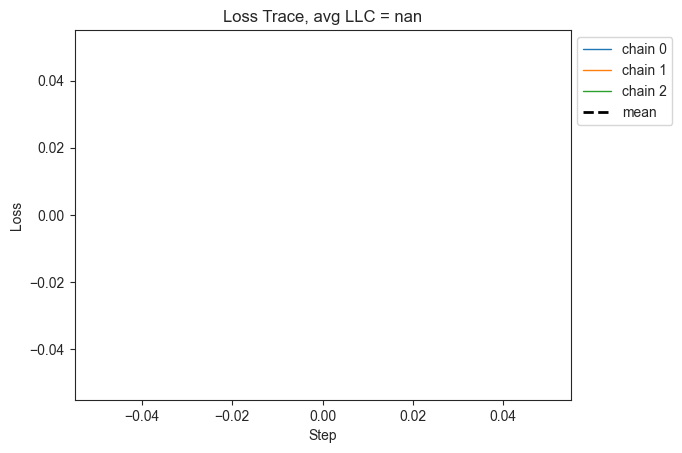

<Figure size 1200x900 with 0 Axes>

In [82]:
if TUNE_HYPERPARAMS:
    print(f"nbeta = {nbeta} gamma = {gamma} lr = {lr}")

    model.load_state_dict(model_checkpoints[60])

    results = estimate_learning_coeff_with_summary(
                    model,
                    loader=train_loader,
                    evaluate=evaluate,
                    sampling_method=SGLD if sampling_method == "sgld" else None,
                    optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=gamma),
                    num_chains=num_chains,                  # How many independent chains to run
                    num_draws=num_draws,                    # How many samples to draw per chain
                    num_burnin_steps=num_burnin_steps,      # How many samples to discard at the beginning of each chain
                    num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
                    device=device,
                    online=True,
                )
    print(f"results.keys() = {results.keys()}")
    plot_trace(
        results["llc/trace"],
        "Loss",
        x_axis="Step",
        title=f"Loss Trace, avg LLC = {sum(results['llc/means']) / len(results['llc/means']):.2f}",
        plot_mean=False,
        plot_std=False,
        fig_size=(12, 9),
        true_lc=None,
    )

### Estimate for model checkpoints

In [10]:
from devinterp.slt.sampler import estimate_learning_coeff_with_summary, estimate_learning_coeff, SGLD
from devinterp.utils import plot_trace

def evaluate(model, data):
    inputs, outputs = data

    return loss_fn(model(inputs), outputs), {
        "logits": model(inputs)
    }

if CREATE_ESTIMATES:
    print(f"Addition frac = {addition_frac} Train frac = {train_frac}")
    print(f"nbeta = {nbeta} gamma = {gamma} lr = {lr}")
    llc_estimates = []

    for saved_model in tqdm.tqdm(model_checkpoints):
        model.load_state_dict(saved_model)
        result = estimate_learning_coeff_with_summary(
                    model,
                    loader=train_loader,
                    evaluate=evaluate,
                    sampling_method=SGLD if sampling_method == "sgld" else None,
                    optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=gamma),
                    num_chains=num_chains,                  # How many independent chains to run
                    num_draws=num_draws,                    # How many samples to draw per chain
                    num_burnin_steps=num_burnin_steps,      # How many samples to discard at the beginning of each chain
                    num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
                    device=device,
                    online=False,
                )
        print(f"result['llc/mean'] = {result["llc/mean"]}")
        llc_estimates.append(result["llc/mean"])

Addition frac = 0.3 Train frac = 0.5
nbeta = 1.6 gamma = 5 lr = 0.03


  0%|          | 0/120 [00:00<?, ?it/s]

Moving model to device:  cpu
Moving model to device:  cpu


/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:118: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:232: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:277: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module impli

Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 190.00it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 216.72it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:00<00:00, 209.26it/s]
/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:118: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(


result['llc/mean'] = 16.479957580566406
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 211.60it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 227.52it/s]


Moving model to device:  cpu


Chain 2:   7%|▋         | 14/200 [00:00<00:00, 221.63it/s]


KeyboardInterrupt: 

### Save the data

In [314]:
SAVE_LOCATION = "../saves/check_point_50/llc_estimates_0.3.pth"

if CREATE_ESTIMATES:
    os.makedirs(Path(SAVE_LOCATION).parent, exist_ok=True)
    torch.save({
        "llc_estimates": llc_estimates,
        "lr": lr,
        "nbeta": nbeta,
        "gamma": gamma,
        "num_chains": num_chains,
        "num_draws": num_draws,
        "num_burnin_steps": num_burnin_steps,
        "num_steps_bw_draws": num_steps_bw_draws,
        "sampling_method": sampling_method,
        "train_frac": train_frac,
        "addition_frac": addition_frac,
        "LOAD_LOCATION": LOAD_LOCATION,
    }, SAVE_LOCATION)
    print(f"addition_frac = {addition_frac} train_frac = {train_frac}")
    print(f"Saved to {SAVE_LOCATION}")

addition_frac = 0.3 train_frac = 0.5
Saved to ../saves/check_point_50/llc_estimates_0.3.pth


### Load data

In [10]:
LOAD_DATA_PATH = "../saves/check_point_50/llc_estimates_0.5.pth"
if not CREATE_ESTIMATES:
    cached_data = torch.load(LOAD_DATA_PATH, weights_only=False)
    llc_estimates = cached_data['llc_estimates']
    lr = cached_data['lr']
    nbeta = cached_data['nbeta']
    gamma = cached_data['gamma']
    num_chains = cached_data['num_chains']
    num_draws = cached_data['num_draws']
    num_burnin_steps = cached_data['num_burnin_steps']
    num_steps_bw_draws = cached_data['num_steps_bw_draws']
    sampling_method = cached_data['sampling_method']
    train_frac = cached_data['train_frac']
    addition_frac = cached_data['addition_frac']
    training_data_path = cached_data['LOAD_LOCATION']
    print(f"addition_frac = {addition_frac} train_frac = {train_frac} len(llc_estimates) = {len(llc_estimates)}")
    print(f"Estimate created from {training_data_path}")

    training_data = torch.load(training_data_path, weights_only=False)
    train_losses = training_data['train_losses']
    test_losses = training_data['test_losses']
    add_test_losses = training_data['add_test_losses']
    multi_test_losses = training_data['multi_test_losses']
    print(f"len(train_losses) = {len(train_losses)} len(test_losses) = {len(test_losses)}")

addition_frac = 0.5 train_frac = 0.5 len(llc_estimates) = 120
Estimate created from ../saves/check_point_50/grokking_add_multi_0.5.pth
len(train_losses) = 6000 len(test_losses) = 6000


## Make some cool graphs

In [313]:
average_window = 5
llc_estimates_avg = rolling_average(llc_estimates, average_window)
line(llc_estimates, xaxis="Epoch", yaxis="LLC", title=f"LLC - addition_frac = {addition_frac} nbeta = {nbeta} epsilon = {lr} gamma = {gamma}", log_y=False, toggle_x=True, toggle_y=True)
line(llc_estimates_avg, xaxis="Epoch", yaxis="Rolling Average LLC", title="Learning Coefficient Estimates", log_y=False, toggle_x=True, toggle_y=True)